<a href="https://colab.research.google.com/github/david-adewoyin/NeuralStyleTransfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tensorflow Inplementation of "A Neural Algorithm of Artistic Style"

This notebook illustrates a Tensorflow implementation of the paper [“A Neural Algorithm of Artistic Style”](https://arxiv.org/abs/1508.06576) which is used to transfer the art style of one picture to another picture’s contents.
The system uses neural representations to seperate and recombine content and style of arbitrary images, providing a neural algorithm for the creation of artistic images.

In [1]:
# importing required packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
IMG_WIDTH = 300
IMG_HEIGHT = 300

content_image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://user-images.githubusercontent.com/57121852/197607208-1d514b22-899c-4ee9-9966-b0325545c71f.jpgng_new.jpg')
style_image_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [3]:
## Specifying the Hyperparameters of the network

ALPHA = 1           # weight to emphasis content loss
BETA = 1e-1         # weight to emphasis style loss

In [4]:
## we using vgg as the backbone of our neural style transfer architecture
vgg = tf.keras.applications.vgg19.VGG19(
    include_top = False,
    input_shape = (IMG_HEIGHT,IMG_WIDTH,3),
)
vgg.trainable = False

In [5]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 600, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 600, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 300, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 300, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 300, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 150, 150, 128)     0     

To obtain a representation of the content image,we capture feature response in higher layers of the network, the idea being higher layers of the network captures information in terms of objects and their arrangment without paying attention to their exact pixel values.

 While to obtain a representation of the style of an input image, we extract both low level features such as (textures,etc..) and high level representation from different layers to build a feature correlation of multiple layers with the purpose of capturing its texture information but not the global arrangement.

In [6]:
## The names of the various layers of the vgg network we need for the style representation and the respective weight
STYLE_LAYERS = [
    ('block1_conv1',1),
    ('block2_conv2',1),
    ('block3_conv4',2),
    ('block4_conv4',5),
    ('block5_conv4',5),
]

## The name of the layer we need for the content representation
CONTENT_LAYER = [
   ('block5_conv2',1)
]

In [7]:
layers = STYLE_LAYERS + CONTENT_LAYER

# we build our custom model on the vgg
# the model has multiple outputs given an input image corresponding to the output produced at the layers defined above
def custom_model(vgg,layers):
  input = vgg.input
  outputs = [vgg.get_layer(layer[0]).output for layer in layers]
  model = tf.keras.Model(inputs = input, outputs = outputs) 
  return model

In [8]:
def load_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)
  # resize the image according while perserving the aspect ratio
  img  = tf.image.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  # Tensorflow expect our image to have an extra dimension corresponding to the batch size (in this case 1)
  img  = tf.expand_dims(img,axis = 0)
  return img

In [9]:
def imshow(image,title=None):
  if len(image.shape)>3:
    image = tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
      plt.title(title)

In [10]:
model = custom_model(vgg,layers)
content_img = load_img(content_image_path)
style_img   = load_img(style_image_path) 

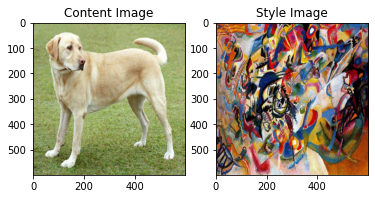

In [11]:
plt.subplot(1,2,1)
imshow(content_img,'Content Image')

plt.subplot(1,2,2)
imshow(style_img,'Style Image')

In [12]:
def content_cost(content_map,generated_map):
  # the content cost determines how well our generated_image matches the content image
  content_map = content_map[-1]
  generated_map = generated_map[-1]
  
  _,n_H,n_W,n_C = content_map.shape
  c_unrolled = tf.reshape(content_map, shape = [1,-1,n_C])
  g_unrolled = tf.reshape(generated_map, shape = [1,-1,n_C])

  #compute cost
  sq = tf.square(c_unrolled - g_unrolled)
  cost = tf.reduce_sum(sq)/(4*n_H*n_W*n_C)
  return cost

In [13]:
# gram matrix is need to compute the style cost at each layer
# it tells us how similar the activation of one filter is to another filter in the same layer
def Gram_Matrix(A):
  A_t = tf.transpose(A)
  return tf.matmul(A,A_t)

In [14]:
def style_at_layer_cost(style_map,generated_map):
  ## the cost is calcuated for each layer defined  in the STYLE_LAYERS
  _,n_H,n_W,n_C = style_map.shape
  s_unrolled = tf.transpose(tf.reshape(style_map, shape = [-1,n_C]))
  g_unrolled= tf.transpose(tf.reshape(generated_map, shape = [-1,n_C]))

  s_gram = Gram_Matrix(s_unrolled)
  g_gram = Gram_Matrix(g_unrolled)

  #compute cost
  sq = tf.square(s_gram - g_gram)
  cost = tf.reduce_sum(sq) /(4*(n_H * n_W *n_C)**2 )## (4 * n_H * n_W *n_C)**2 is based on the original paper
  return cost


In [15]:
def style_cost(style_map,generated_map,STYLE_LAYERS = STYLE_LAYERS):
  # calculate the total cost across all layers

  style_map = style_map[:-1] ## fetch all style layers except the content layer
  generated_map = generated_map[:-1]
  
  cost = 0
  for i,weight in zip(range(len(style_map)),STYLE_LAYERS):
    J_style_layer = style_at_layer_cost(style_map[i],generated_map[i])
    cost += J_style_layer * weight[1]
  return cost


In [16]:
def preprocess_image(image):
  img = tf.keras.applications.vgg19.preprocess_input(image*255.0)
  return img

In [17]:
def generate_image(content_image):
  # generate an image from the combination of a noise and the content image
  generated_image = tf.Variable(tf.image.convert_image_dtype(content_image,tf.float32))
  noise_image = tf.random.uniform(tf.shape(generated_image),-0.1,0.1)

  generated_image = tf.add(generated_image,noise_image)
  generated_image = tf.clip_by_value(generated_image,clip_value_min =0.0, clip_value_max=1.0)

  return generated_image 


In [18]:
def tensor_to_image(tensor):
  """
  Convert the given tensor into a PIL image
  """
  tensor = tensor *255.0
  tensor = np.array(tensor,dtype = np.uint8)
  if np.ndim(tensor) >3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

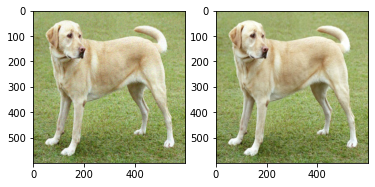

In [19]:
content_image = tf.constant(preprocess_image(content_img))
style_image = tf.constant(preprocess_image(style_img))

generated_image = generate_image(content_img)
generated_image = tf.Variable(generated_image)

_,ax = plt.subplots(1,2)
ax[0].imshow(generated_image[0])
ax[1].imshow(content_img[0])

In [20]:
a_S = model(style_image)
a_C =  model(content_image)

Defining our training step

In [21]:
optimizer = tf.keras.optimizers.Adam(0.02)
@tf.function()
def train_step(generated_image,variation_weight = 1):
  with tf.GradientTape() as tape:

    a = preprocess_image(generated_image)
    a_G = model(a)

    J_style   = style_cost(a_S,a_G)
    J_content = content_cost(a_C,a_G)

    J = ALPHA *J_content + BETA * J_style
    vari_loss =variation_weight * tf.reduce_sum(tf.image.total_variation(generated_image))
    J+= vari_loss

  grad = tape.gradient(J,generated_image)
  optimizer.apply_gradients([(grad,generated_image)])
  clipped = tf.clip_by_value(generated_image,0.0,1.0)
  generated_image.assign(clipped)
  return J

Epoch 500


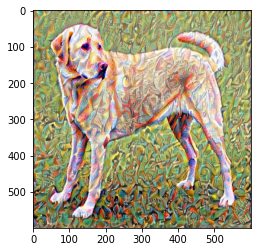

Epoch 1000


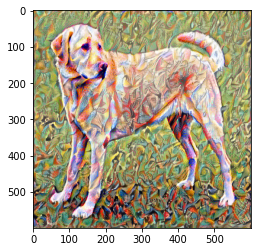

Epoch 1500


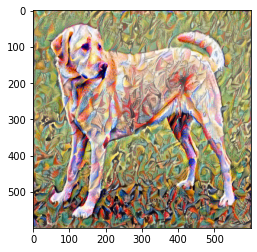

In [22]:
epochs = 2_000
for i in range(epochs):
  train_step(generated_image,variation_weight=1)
  if i % 500 == 0 and i != 0 :
    print(f"Epoch {i}")
    image = tensor_to_image(generated_image)
    plt.imshow(image)
    plt.show()
    if i% 500 == 0:
      image.save(f"image{i}conv{i}.jpg")


In [23]:
tensor_to_image(generated_image)
image.save(f"stylized.jpg")

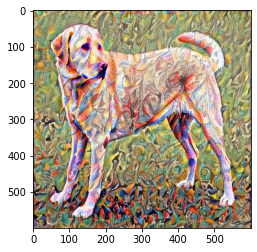

In [25]:
imshow(generated_image)